In [1]:
from thought_tracing import ThoughtTracing
from prompt_templates import *
from datasets import load_dataset
import os
from tqdm import tqdm

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
n = 100

dataset = load_dataset("Chuanyang-Jin/MMToM-QA")
dataset = dataset.map(lambda example, idx: {"id": idx}, with_indices=True)
dataset = dataset["train"].shuffle(seed=43).select(range(n))

In [3]:
print(dataset[0])

{'question': "What's inside the apartment: The apartment consists of a bedroom, kitchen, living room, and bathroom. \nIn the bedroom, there is a coffee table and a desk, with a water glass and a wine glass placed on the coffee table. \nThe kitchen is equipped with four cabinets, a fridge, a kitchen table, a microwave, and a stove. The first cabinet from the left contains a water glass, the second and third cabinets each hold a dish bowl, while the fourth cabinet stores a dish bowl and a bag of chips. The fridge is empty, the microwave houses a plate, and the stove contains a cupcake, a plate, and a salmon. \nThe living room features a cabinet, a sofa, a coffee table, and a desk. The cabinet is filled with three remote controls, a water glass, three apples, two cupcakes, a wine glass, a condiment bottle, a bottle of wine, and two books. \nLastly, the bathroom has a bathroom cabinet, which is currently empty. \nActions taken by Mary: Mary is situated in the kitchen. She strides towards t

In [4]:
overall_acc = []
overall_tokens = []
modes = ["Trace", "CoT", "Hybrid"]

for mode in modes:
    n = 0
    thought_tracing = ThoughtTracing(
        parse_prompt=parse_prompt,
        hypothesis_prompt=hypothesis_prompt,
        rejuvenate_prompt=rejuvenate_prompt,
        summary_prompt=summary_prompt,
        CoT_prompt=CoT_prompt,
        conclusion_prompt=conclusion_prompt,
        mode=mode,
        base_model="gpt-4o",
        temperature=0.23,
        max_steps=10,
        uncertainty_threshold=0.2,
        N=5,
    )

    total_acc = 0
    total_tokens = (0, 0)

    os.makedirs(f"./{mode}_failed_cases", exist_ok=True)
    print(mode)
    for i in tqdm(range(len(dataset))):
        raw = dataset[i]["question"].split("Question:")
        input = "".join(raw[:-1])
        question = raw[-1]
        answer = dataset[i]["answer"]
        acc, model_answer, reasoning, history, tokens = thought_tracing.infer(input, question, answer)
        if acc == -1:
            continue
        elif acc == -2:
            print("Case", dataset[i]['id'], "parsing error")
            continue
        n += 1
        if not acc:
            with open(f"./{mode}_failed_cases/{dataset[i]['id']}.txt", "w") as f:
                f.write(f"Input: {dataset[i]['question']}\n")
                f.write(f"Answer: {answer}\n")
                f.write(f"Model Answer: {model_answer}\n")
                f.write(f"Model Reasoning: {reasoning}\n")
                f.write(f"History: {history}\n")
        total_acc += int(acc)
        total_tokens = (total_tokens[0] + tokens[0], total_tokens[1] + tokens[1])
    print(total_acc / n)
    print(n)
    print(total_tokens)
    overall_acc.append(total_acc / n)
    overall_tokens.append((total_tokens[0] / n, total_tokens[1] / n))

Trace


100%|██████████| 100/100 [46:04<00:00, 27.64s/it]


0.8208955223880597
67
(784198, 151815)
CoT


100%|██████████| 100/100 [22:47<00:00, 13.68s/it]


0.927536231884058
69
(473187, 66215)
Hybrid


 83%|████████▎ | 83/100 [48:09<08:22, 29.54s/it]  

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
```json
{
  "Reason": Karen has moved from the bedroom to the bathroom and now to the kitchen, checking containers in each room. She opened the bathroom cabinet, which was empty, and now she is in the kitchen. Her action of opening the fridge suggests she believes the object she wants might be in the fridge. She has not yet checked the stove or the microwave, indicating she might check them if the fridge does not contain what she is looking for. Her exploration pattern suggests she is systematically searching for a specific object, but it is not clear what that object is based on her actions so far. 
  "Thought": Karen believes the object she wants might be in the fridge. Her intention is to find a specific object, and she is systematically checking containers in the apartment to locate it.
}
```
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

100%|██████████| 100/100 [1:02:00<00:00, 37.21s/it]

0.7971014492753623
69
(1159093, 200562)


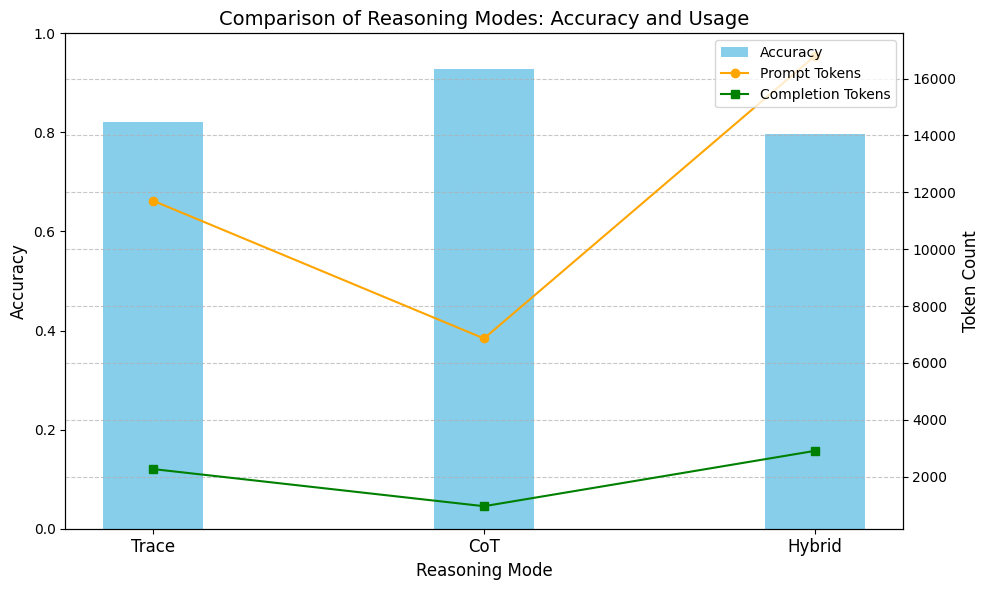

In [7]:
import matplotlib.pyplot as plt
import numpy as np

prompt_tokens = [i[0] for i in overall_tokens]
completion_tokens = [i[1] for i in overall_tokens]
x = np.arange(len(modes))
width = 0.3

fig, ax1 = plt.subplots(figsize=(10, 6))

bars = ax1.bar(x, overall_acc, width, label='Accuracy', color='skyblue')
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_ylim(0, 1)
ax1.set_xticks(x)
ax1.set_xticklabels(modes, fontsize=12)
ax1.set_xlabel('Reasoning Mode', fontsize=12)
ax1.set_title('Comparison of Reasoning Modes: Accuracy and Usage', fontsize=14)

ax2 = ax1.twinx()
ax2.plot(x, prompt_tokens, marker='o', label='Prompt Tokens', color='orange')
ax2.plot(x, completion_tokens, marker='s', label='Completion Tokens', color='green')
ax2.set_ylabel('Token Count', fontsize=12)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

In [6]:
thought_tracing.avg_uncertainty

np.float64(0.30840587818352466)

In [9]:
n = 0
thought_tracing = ThoughtTracing(
    parse_prompt=parse_prompt,
    hypothesis_prompt=hypothesis_prompt,
    rejuvenate_prompt=rejuvenate_prompt,
    summary_prompt=summary_prompt,
    CoT_prompt=CoT_prompt,
    conclusion_prompt=conclusion_prompt,
    mode=mode,
    base_model="gpt-4o",
    temperature=0.23,
    max_steps=10,
    uncertainty_threshold=0.31,
    N=5,
)

total_acc = 0
total_tokens = (0, 0)

os.makedirs(f"./{mode}_failed_cases", exist_ok=True)
print(mode)
for i in tqdm(range(len(dataset))):
    raw = dataset[i]["question"].split("Question:")
    input = "".join(raw[:-1])
    question = raw[-1]
    answer = dataset[i]["answer"]
    acc, model_answer, reasoning, history, tokens = thought_tracing.infer(input, question, answer)
    if acc == -1:
        continue
    elif acc == -2:
        print("Case", dataset[i]['id'], "parsing error")
        continue
    n += 1
    if not acc:
        with open(f"./{mode}_failed_cases/{dataset[i]['id']}.txt", "w") as f:
            f.write(f"Input: {dataset[i]['question']}\n")
            f.write(f"Answer: {answer}\n")
            f.write(f"Model Answer: {model_answer}\n")
            f.write(f"Model Reasoning: {reasoning}\n")
            f.write(f"History: {history}\n")
    total_acc += int(acc)
    total_tokens = (total_tokens[0] + tokens[0], total_tokens[1] + tokens[1])
print(total_acc / n)
print(n)
print(total_tokens)
overall_acc[2] = total_acc / n
overall_tokens[2] = (total_tokens[0] / n, total_tokens[1] / n)

Hybrid


100%|██████████| 100/100 [57:53<00:00, 34.74s/it] 

0.8382352941176471
68
(708462, 114902)


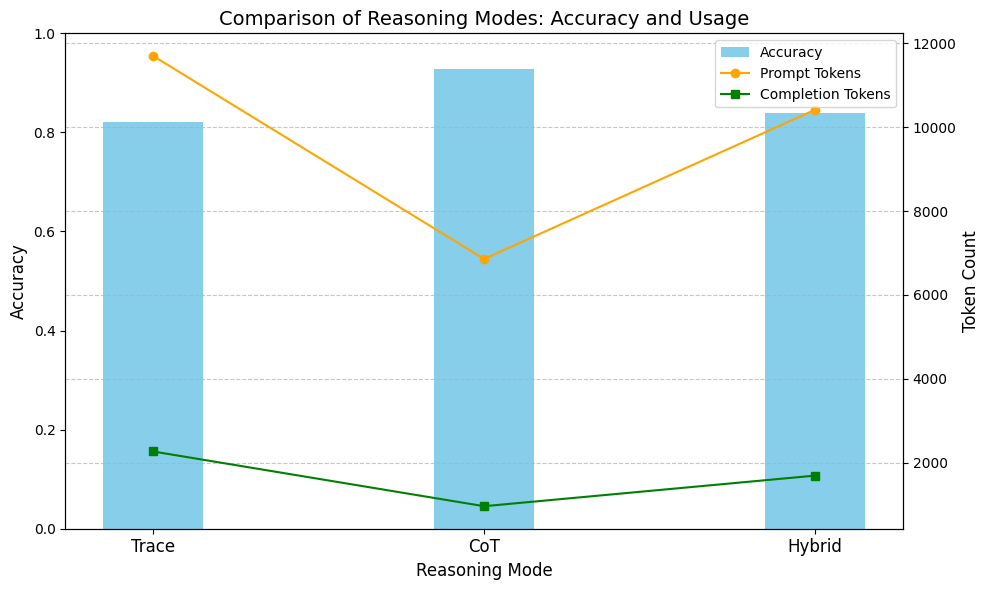

In [10]:
import matplotlib.pyplot as plt
import numpy as np

prompt_tokens = [i[0] for i in overall_tokens]
completion_tokens = [i[1] for i in overall_tokens]
x = np.arange(len(modes))
width = 0.3

fig, ax1 = plt.subplots(figsize=(10, 6))

bars = ax1.bar(x, overall_acc, width, label='Accuracy', color='skyblue')
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_ylim(0, 1)
ax1.set_xticks(x)
ax1.set_xticklabels(modes, fontsize=12)
ax1.set_xlabel('Reasoning Mode', fontsize=12)
ax1.set_title('Comparison of Reasoning Modes: Accuracy and Usage', fontsize=14)

ax2 = ax1.twinx()
ax2.plot(x, prompt_tokens, marker='o', label='Prompt Tokens', color='orange')
ax2.plot(x, completion_tokens, marker='s', label='Completion Tokens', color='green')
ax2.set_ylabel('Token Count', fontsize=12)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()